## Party list
- 64360612 กิติพงษ์ สายยศ
- 64362968 ธิติพล แพ่งเมือง
- 64366584 สุปกาณฑ์ อ่วมวงษ์
- 64366744 สุวัชชัย พิณเนียม
- 64365570 วัชระพงศ์ รอดพงษ์

##### ----------------------------------------------------

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from scipy.fftpack import dct
from sklearn.metrics import accuracy_score
import seaborn as sns

#### Load the MNITS digits Data set using tensorflow

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

#### Model with no Features Engineering with Discrete Cosine Transform

In [3]:
x_train = x_train.reshape(-1, 28 * 28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28 * 28).astype('float32') / 255.0
model = GaussianNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Naive Bayes on DCT features: {accuracy:.2f}')

Accuracy of Naive Bayes on DCT features: 0.56


#### Normalize feature dataset and Feature Engineering
- normalize pixel values
- Discrete Cosine Transform

In [3]:
def apply_dct(images):
    dct_features = []
    for image in images:
        dct_image = dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')
        dct_features.append(dct_image.flatten())
    return np.array(dct_features)

In [4]:
# Reshape from 3D Array to 2D Array
x_train = x_train.reshape(-1, 28 , 28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28 , 28).astype('float32') / 255.0
x_train = apply_dct(x_train)
x_test = apply_dct(x_test)

## Guassian Naive Bayes Model

In [6]:
model = GaussianNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

## Confusion Matrix

In [7]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
confusion_matrix

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 886,    0,   17,    0,   16,   23,   19,    0,   16,    3],
       [   1, 1049,   22,    1,   17,    0,    3,   14,   26,    2],
       [  13,    0,  841,   33,   10,   47,   28,    3,   53,    4],
       [   8,    0,   40,  840,    4,   58,    5,    2,   31,   22],
       [   3,    1,   22,    0,  859,    1,   39,    7,   21,   29],
       [  10,    0,   12,  116,    3,  699,    5,    6,   31,   10],
       [  17,    1,   50,    0,   51,   21,  803,    0,   15,    0],
       [   2,    2,   79,    5,   38,   20,    0,  818,    6,   58],
       [  32,    0,   43,   27,   18,   20,    6,    3,  794,   31],
       [   9,    4,   40,    8,   58,   24,    6,   36,   33,  791]])>

In [8]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Naive Bayes on DCT features: {accuracy:.2f}')

Accuracy of Naive Bayes on DCT features: 0.84


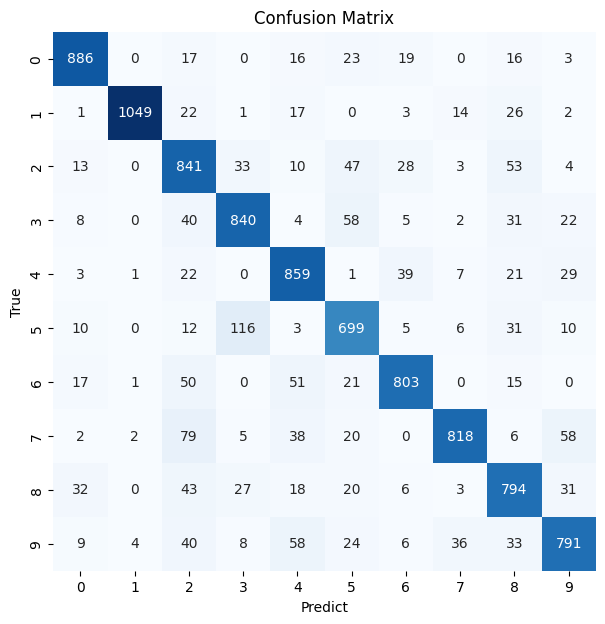

In [9]:
plt.figure(figsize=(7, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Classification Report
- Precision
- Recall
- F1-Score
- Accuracy

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

precision_ = precision_score(y_test, y_pred, average='weighted')
recall_ = recall_score(y_test, y_pred, average='weighted')
f1_ = f1_score(y_test, y_pred, average='weighted')

accuracy_ = accuracy_score(y_test, y_pred)

_metrics = {
    'Precision': precision_,
    'Recall': recall_,
    'F1-Score': f1_,
    'Accuracy': accuracy_
}

df_matrix = pd.DataFrame([_metrics])
print("Classification Report")
df_matrix

Classification Report


,Precision,Recall,F1-Score,Accuracy
0,0.842932,0.838,0.839216,0.838


## Hyperparameter Tuning

Variance smoothing is the process of adding a small constant (called a smoothing parameter or smoothing constant) to the variance of each class of data to counteract the problem of low or zero variance, especially in cases where the number of samples in some classes is too small, which can make the model unstable when calculating classification.

In [1]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=42)

In [12]:
from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gridSearch_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

data_transformed = PowerTransformer().fit_transform(x_test)

gridSearch_NB.fit(data_transformed, y_test);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [13]:
print("Best Parameter: ", gridSearch_NB.best_params_)
print("Best Score: ", gridSearch_NB.best_score_)

Best Parameter:  {'var_smoothing': 0.03511191734215131}
Best Score:  0.8357666666666667


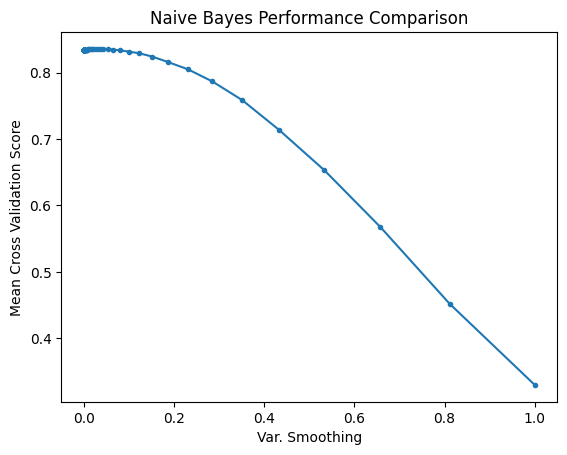

In [14]:
results_NB = pd.DataFrame(gridSearch_NB.cv_results_['params'])
results_NB['test_score'] = gridSearch_NB.cv_results_['mean_test_score']

plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean Cross Validation Score")
plt.title("Naive Bayes Performance Comparison")
plt.show()

In [15]:
best_model = gridSearch_NB.best_estimator_  # Best model
predict_test = best_model.predict(data_transformed)

accuracy_test = accuracy_score(y_test, predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.8501


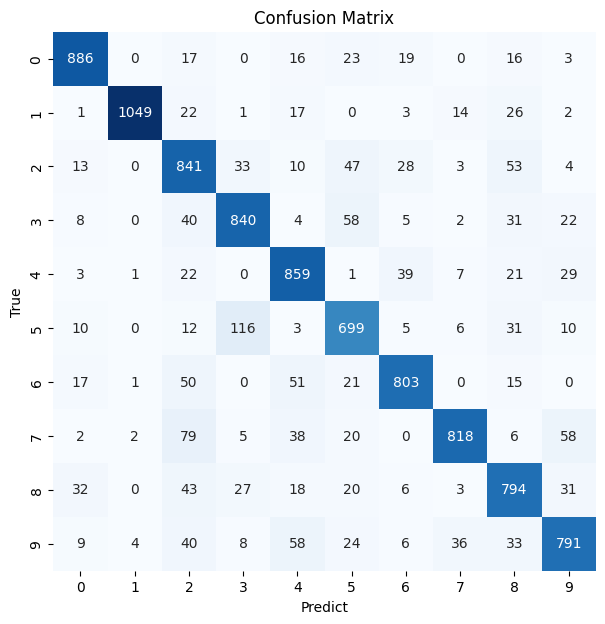

In [16]:
confusm = tf.math.confusion_matrix(y_test, predict_test)

plt.figure(figsize=(7, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
precision_1 = precision_score(y_test, predict_test, average='weighted')
recall_1 = recall_score(y_test, predict_test, average='weighted')
f1_1 = f1_score(y_test, predict_test, average='weighted')

accuracy_1 = accuracy_score(y_test, predict_test)

_metrics1 = {
    'Precision': precision_1,
    'Recall': recall_1,
    'F1-Score': f1_1,
    'Accuracy': accuracy_1
}

df_matrix1 = pd.DataFrame([_metrics1])

df_matrix1

,Precision,Recall,F1-Score,Accuracy
0,0.855012,0.8501,0.851349,0.8501


## Show an image that Predict incorrect and correct

In [18]:
def display_one_prediction(images, true_labels, pred_labels):
    correct = np.where(true_labels == pred_labels)[0]
    incorrect = np.where(true_labels != pred_labels)[0]

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    if len(correct) > 0:
        random_correct = np.random.choice(correct)
        axs[0].imshow(images[random_correct].reshape(28, 28), cmap='gray')
        axs[0].set_title(f"Correct\nPred: {pred_labels[random_correct]}, True: {true_labels[random_correct]}")
    else:
        axs[0].axis('off')

    if len(incorrect) > 0:
        random_incorrect = np.random.choice(incorrect)
        axs[1].imshow(images[random_incorrect].reshape(28, 28), cmap='gray')
        axs[1].set_title(f"Incorrect\nPred: {pred_labels[random_incorrect]}, True: {true_labels[random_incorrect]}")
    else:
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# invert discrete cosine transform
from scipy.fftpack import idct

def apply_idct(dct_images):
    idct_features = []
    for dct_image in dct_images:
        idct_image = idct(idct(dct_image.reshape(28, 28), axis=1, norm='ortho'), axis=0, norm='ortho')
        idct_features.append(idct_image)
    return np.array(idct_features)

In [19]:
x_test_inverted = apply_idct(x_test)
x_test_reshaped_inverted = x_test_inverted.reshape(-1, 28, 28)

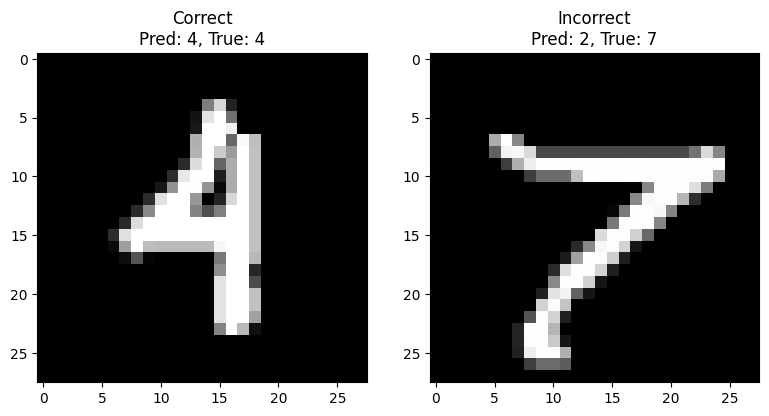

In [20]:
# Display Image that Predicted correct and Incorrect...
display_one_prediction(x_test_reshaped_inverted, y_test, predict_test)

## Compare between Hyperparameter Tuning

In [21]:
print("\nBefore Tuning...")
print(df_matrix)
print("\n----------------------------------------------------\n")
print("After Tuning...")
print(df_matrix1)


Before Tuning...
   Precision  Recall  F1-Score  Accuracy
0   0.842932   0.838  0.839216     0.838

----------------------------------------------------

After Tuning...
   Precision  Recall  F1-Score  Accuracy
0   0.855012  0.8501  0.851349    0.8501


In [24]:
import joblib

joblib.dump(best_model, 'model/nb_mnist_model.pkl')

['model/nb_mnist_model.pkl']